In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples): #@save
    """ 生成 y=Xw+b+噪声 """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.6780, -3.3981]) 
label: tensor([14.3932])


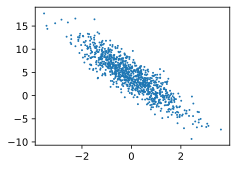

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [5]:
features[:, 1]

tensor([-3.3981e+00,  2.3304e+00, -3.5619e-01,  8.8668e-01, -4.6404e-01,
        -9.0132e-01,  3.0279e+00,  5.4009e-01,  1.0185e-01,  8.3877e-01,
         9.9578e-02, -1.4667e+00,  6.6884e-01, -1.1832e-01, -9.0408e-01,
         4.4705e-01,  1.6328e+00, -4.1456e-02, -1.5567e-01,  1.5260e+00,
         1.0640e+00, -7.6651e-02,  8.6943e-01, -7.9187e-03, -1.2159e+00,
         3.6200e+00, -5.8744e-01,  2.6481e+00,  1.4946e+00,  6.1772e-01,
        -2.1587e+00, -6.2429e-01,  3.0669e+00,  1.8462e+00,  1.3314e+00,
         2.6705e-01,  1.4396e+00,  2.4325e+00,  1.3068e+00, -9.6264e-01,
        -1.8820e-01, -1.5116e+00,  1.8964e+00,  2.7886e-01, -4.6422e-01,
        -3.0282e-01,  1.1655e+00,  9.5881e-01, -1.4919e+00, -8.7738e-01,
        -1.0195e+00, -1.5826e+00, -1.3579e+00, -4.1351e-01,  2.8438e-01,
         1.4573e+00, -8.8600e-01, -4.2311e-01,  3.2179e-01,  6.8207e-01,
        -1.0577e+00,  9.2330e-01,  3.7092e-01, -2.2019e-01, -1.0328e-01,
         2.4534e-03, -1.0091e+00,  7.8791e-01,  1.2

## 读取数据集

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.8208, -0.1209],
        [ 1.2902, -0.8947],
        [-1.0073,  1.9456],
        [-1.2773,  1.8572],
        [-1.3552,  0.6789],
        [-0.4269,  1.0283],
        [ 1.4404, -1.1510],
        [-1.9326, -1.1815],
        [ 2.2563, -0.3974],
        [-0.8495, -0.2850]]) 
 tensor([[ 0.9579],
        [ 9.8266],
        [-4.4420],
        [-4.6642],
        [-0.8273],
        [-0.1615],
        [10.9866],
        [ 4.3487],
        [10.0746],
        [ 3.4839]])


In [30]:
# 初始化参数，设置允许梯度下降
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# w = torch.zeros((2, 1), requires_grad=True)

In [11]:
# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [12]:
# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    # 这里reshape是为了避免 标签y为行向量而y_hat为列向量
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [13]:
# 定义优化算法
# 该函数接受模型参数集合、学习速率和批量大小作为输入
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 上面定义的损失函数没有除以样本数，这里需要除以批量样本数
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [31]:
# 开始训练
lr = 0.03 # 学习率
num_epochs = 3 # 迭代周期个数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        # 利用模型计算整个数据的误差
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.243433
epoch 2, loss 0.003616
epoch 3, loss 0.000101


In [21]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([1.4067e-05, 4.7350e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


(tensor([[ 1.9999],
         [-3.4001]], requires_grad=True),
 tensor([4.1991], requires_grad=True))

(tensor([ 2.0000, -3.4000]), 4.2)